**DESCRIPTION:** This model will run a regression on all of the data by the identifier(s) specified by the user. The regression is completed using SKLearn which utilizes test and training data to fit a learned model to the data. The model will then be used to complete a factor selection and forward/backward factor selection which can be used to fine-tune the model.

**How to Run This Code:** Run each segment of code and markdown in order using the 'Run' button above. Once you have run the last segment the code will execute and results will be outputted. It may take a few moments for the code to output results so please be patient.

In [43]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from time import time
from sklearn.feature_selection import SequentialFeatureSelector
import warnings
warnings.filterwarnings('ignore')
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

**Calculating the Model:** The function below calculates and plots our model given a datatable. Comments included in the code provide a description of what is occuring in each step.

**Arranging the Data:** This function will arrange our data based on the given dataset to turn the dates into the index of the graph to allow for the regression to occur over the dates.

In [44]:
def arrange_data(data, iden):
    
    data.set_index(pd.DatetimeIndex(data['date']), inplace=True)

    df = data.loc[data['identifier'] == iden]
    
    return df

**Getting the Training and Testing Data:** This code sets the predictor values, i.e. the independent variables that will be used in the regression and uses the train_test_split to randomly select 30% of the data as testing data, saving the rest for the creation/training of the model.

In [45]:
def get_train_and_test_data(data, predictor_list):

    predictors = predictor_list

    train, test = train_test_split(data, test_size=0.3)
    
    return [train, test]

**Running the Linear Regression:** This function conducts the linear regression by fitting thr model to the predictors and training data. It then creats predictions for the data using model.predict and using the index we set previously.

In [46]:
def linear_model(train, test, predictors):
    
    # Defines the model as a Linear Regression
    model = LinearRegression()

    # Fits the model using the predictors above and defined target training data
    model.fit(train[predictors], train["target"])

    # Creates the predictors using the model.predict
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index)
    
    return preds

**Calculating r^2:** This function calculates the r^2 of the model by utilizing the r2_score function with the test target data and predictions from the model.

In [47]:
def r2(preds, test, iden):
    
    # Calculates the r^2 score based on the test values and the predicted values
    r = r2_score(test["target"], preds)
    
    print("r2 of " + iden + " =" + str(r))
    
    return r

**Graphing the Results:** This function creates a graph that plots the predictions of the model against the true values of the test target data.

In [48]:
def graph_preds_vs_test(preds, test, iden):
    # Creates a graph that plots the predictions of the model against true values
    combined = pd.concat({"target": test["target"], "Predictions": preds},
                         axis=1)

    # Plots the origional vs predicted
    combined.plot()
    plt.title(iden)
    plt.show()

**K Fold Test:** Conducts a k_fold test on the data using the predictors (X) and response variables (y) using the KFold function. It then Calculates the cross validation score which is later used to calculate the Root Mean Squared Error. The RMSE is useful as it provides information regarding the accuracy of our model - i.e. the lower the RMSE the better

In [49]:
def k_fold_test(predictor_list, train, model, X, y):

    # Conducts the K_Fold test
    cv = KFold(n_splits=10, random_state=100, shuffle=True)

    scores = cross_val_score(model, train[predictor_list], train["target"],
                             scoring='neg_mean_absolute_error',
                             cv=cv, n_jobs=-1)
    
    print("root mean squared error (RMSE) = " + str(np.sqrt(np.mean(np.absolute(
        scores)))))

**Features:** Returns the features to be used.

In [50]:
def set_features():
    return ['sector','market_cap', 'index_membership', 'factor_1',
                'factor_2', 'factor_3', 'factor_4', 'factor_5', 'factor_6',
                'factor_7', 'factor_8', 'factor_9', 'factor_10']

**Set X:** Defines our X, i.e. predictors

In [51]:
def set_X(data, predictor_list):
    return data[predictor_list]

**Set Y:** Defines our y, i.e.  response variables

In [52]:
def set_y(data):
    return data['target']

**Ridge Calculation:** Uses RidgeCV to compute efficient Leave-One-Out Cross-Validation. This is an itteration of the Kfold where the number of folds equals the number of instances in the data set. This is advantageous as it is usefull in models that may have multicollinearity.
* Used in feature selection

In [53]:
def ridge_calculation(X, y):
    
    ridge = RidgeCV(alphas = np.logspace(-6, 6, num=5)).fit(X, y)
    
    return ridge

**Calculating the Model:** The function below calculates and plots our model given a datatable. Comments included in the code provide a description of what is occuring in each step.

In [54]:
def individual_idents(data, predictor_list, lst):
    
    # This loops will run the model for each input specified by the user
    
    for iden in lst:
        
        print(iden + ": \n")
    
        # sets a new dataframe equal to the original data
        # this is done so no information is lost in each itteration as the datatable is modified
    
        ds = arrange_data(data, iden)

        model = LinearRegression()

        train_data = get_train_and_test_data(ds, predictor_list)[0]

        test_data = get_train_and_test_data(ds, predictor_list)[1]

        predictions = linear_model(train_data, test_data, predictor_list)

        r_2 = r2(predictions, test_data, iden)

        graph_preds_vs_test(predictions, test_data, iden)

        X = set_X(ds, predictor_list)

        y = set_y(ds)

        k_fold_test(predictor_list, train_data, model, X, y)

        ridge = ridge_calculation(X, y)

        feature_importance(X, y, ridge, iden)

        # Selects the most relevent features using forward and backward
        # Sequential Feature Selection

        features = set_features()

        # TO:DO comment out this once you have run the function once

        seq_selection(X, y, features, ridge, iden)  



**Feature Importance of Coefficients using RidgeCV:** These functions will utilize the RidgeCV computed in the above function to determine the most important fratures based on a relevency threshhold. It also plots the feature importance graph.

In [55]:
# Simple helper function to go from list of True and False to the final selected values

def selecting(lst, features):
    selected = []
    for i in range(0,13):
        if lst[i] == True:
            selected.append(features[i])
    return selected

In [56]:
def feature_importance(X, y, ridge, iden):
        
    # sets the importance as a list of the ridge coefficients calculated for each feature
    importance = list(np.abs(ridge.coef_))

    # re-itterates the features, but using better spacing for graph visibility
    features = ['sector','market \n cap', 'index \n membership', 'factor_1',
            'factor_2', 'factor_3', 'factor_4', 'factor_5', 'factor_6',
            'factor_7', 'factor_8', 'factor_9', 'factor_10']

    # preps a dictionary which scales each 'importance score' by 1000 for visbility
    dta = {}
    importance_2 = []
    
    for i in range(0,13):
        importance_2.append(importance[i] *1000)
        dta[features[i]] = importance_2[i]
    
    # graphs the factors vs importance level
    names = list(dta.keys())
    values = list(dta.values())

    fig, axs = plt.subplots(1, 1, figsize=(16, 3), sharey=True)
    plt.bar(names, values)
    fig.suptitle('Feature importances via coefficients of ' + iden + ' (scaled by 1000)')

    # Selecting features based on importance
    
    # sets a threshold parameter and will select the features whose importance (defined by the coefficients) are above this threshold
    # This specific threshold will select 3 features by setting the threshold slightly above the coefficient of the fourth most important feature
    threshold = np.sort(importance)[-4] + 0.01
    # time is used to show the user how long the calculation took - start
    tic = time()
    # selects the features from the model that are above the threshhold
    sfm = SelectFromModel(ridge, threshold=threshold).fit(X, y)
    # end time calculation
    toc = time()
    # returns the list of features found in sfm, i.e. those above the threshhold
    lst = list(sfm.get_support())
    # prints the results
    print(f"Features of" + iden +  " selected by SelectFromModel:", selecting(lst, features))
    print(f"Done in {toc - tic:.3f}s")

**Selecting features with Sequential Feature Selection:** **Selecting features with Sequential Feature Selection:** SFS is a greedy procedure where, at each iteration, we choose the best new feature to add to our selected features based a cross-validation score (starts with 0 features and choose the best single feature with the highest score. The procedure is repeated until we reach the desired number of selected features) Our function below does this in forward and backward SFS (the reverse of what is described above).

In [57]:
def seq_selection(X, y, features, ridge, iden):

    # Forward Selection
    
    # starts the time
    tic_fwd = time()
    # runs the SequentialFeatureSelector on our ridge values previosuly calculated
    # and specifies that this is to be done in the forward direction
    sfs_forward = SequentialFeatureSelector(
        ridge, n_features_to_select=2, direction="forward"
    ).fit(X, y)
    # stops the time
    toc_fwd = time()
    
    # Backward Selection
    
    # starts the time
    tic_bwd = time()
    # runs the SequentialFeatureSelector on our ridge values previosuly calculated
    # and specifies that this is to be done in the backward direction
    sfs_backward = SequentialFeatureSelector(
        ridge, n_features_to_select=2, direction="backward"
    ).fit(X, y)
    # stops the time
    toc_bwd = time()

    #prints the results
    print(
        "Features of" + iden + " selected by forward sequential selection: ", selecting(sfs_forward.get_support(), features)
    )
    print(f"Done in {toc_fwd - tic_fwd:.3f}s")
    print(
        "Features of" + iden + " selected by backward sequential selection: ", selecting(sfs_backward.get_support(), features)
    )
    print(f"Done in {toc_bwd - tic_bwd:.3f}s")

**Note on Path to File:** Below I have specified the path to the given CSV containing the data. You do not need to change the path for it to work on this notebook, but if you would like to download the code, you may.

What identifier would you like to model? (i.e. KM943MN5D7E3) 
KM943MN5D7E3
Would you like to add another? - answer 'Y' for yes and 'N' for no 
N
KM943MN5D7E3: 

r2 of KM943MN5D7E3 =0.9476334413122856


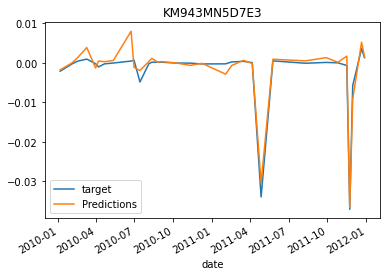

root mean squared error (RMSE) = 0.042925474573420025
Features ofKM943MN5D7E3 selected by SelectFromModel: ['factor_2', 'factor_9']
Done in 0.003s
Features ofKM943MN5D7E3 selected by forward sequential selection:  ['factor_2', 'factor_9']
Done in 0.305s
Features ofKM943MN5D7E3 selected by backward sequential selection:  ['factor_7', 'factor_9']
Done in 1.089s

 Model Complete


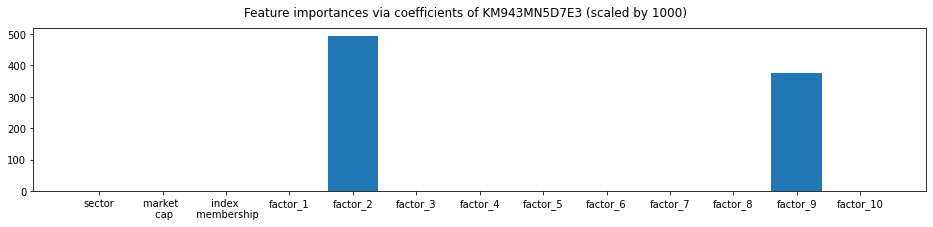

In [58]:
path_to_file = "data/data.csv"

selected = ''

# Reads the information contained in the CSV
og_df = pd.read_csv(path_to_file)

# Prepares a list to hold the identifiers
idents = []

identifier_set = list(set(og_df["identifier"].values.tolist()))

# While loop that will continue to ask the user for input until they answer 
# "N". Each identifier that is added is checked to determine if it is valid.


answer = 'Y'
while (answer == 'Y'):
    n = input("What identifier would you like to model? (i.e. KM943MN5D7E3) \n")
    if(n in identifier_set):
        idents.append(n)
        answer = input(
        "Would you like to add another? - answer 'Y' for yes and "
        "'N' for no \n")
    else:
        answer = input("Your input is not an identifier. Would you like to try again? - answer 'Y' for yes and "
        "'N' for no \n")
        
predictors = ['market_cap', 'sector', 'index_membership', 'factor_1',
                  'factor_2', 'factor_3', 'factor_4', 'factor_5', 'factor_6',
                  'factor_7', 'factor_8', 'factor_9', 'factor_10']
        

# Runs the model on the given identifiers
individual_idents(og_df, predictors, idents)

# signals that the code has run to completion
print('\n Model Complete')